In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

np.random.seed(100)

# Abstract

# Introduction

Some of this is really more the background.

Within this project, various schemes for computational simulation of N-Body problems are considered. In general, these problems consider $N$ different bodies, which all interact with all other $N-1$ bodies within the simulation. Naive implementation of these algorithms will therefore have time scaling of $O(N^2)$, quickly becoming infeasible for large numbers of particles. Here we consider the Barnes-Hut (BH) and Fast Multipole Method (FMM) schemes **references to papers**, for large $N$, these schemes provide $O(N \log(N))$ and $O(N)$ scaling, a significant improvement over simple pairwise interaction. 

Within this report we constrict our consideration to pairwise interaction due to solutions of Poisson's Equations in 2D, that being solutions to the equation of the form, 
$$
\nabla^2 \varphi(x, y) = \left(\frac{\partial^2}{\partial x} + \frac{\partial^2}{\partial x} \right) \varphi(x, y) = f(x, y) \, .
$$
Physically, the most common manefestations of this appears within gravity, 
$$
\nabla^2 \phi = 4 \pi G \rho
$$
and Coloumb interaction
$$
\nabla^2 \phi = - \frac{\rho}{\epsilon} \, .
$$

In the case of the Coloumb interaction, for a point of unit charge (with $\epsilon = 1$) at $(x_0, y_0) = \mathbf{x}_0 \in \mathbb{R}^2$, then at any other $(x, y) = \mathbf{x} \in \mathbb{R}^2$, the potential and electrostatic field are given as, 
$$
\phi_{\mathbf{x}_0}(x, y) = - \log(\| \mathbf{x} - \mathbf{x}_0 \|), \quad \mathbf{E}_{\mathbf{x}_0}(x, y) = \frac{(\mathbf{x} - \mathbf{x}_0)}{\| \mathbf{x} - \mathbf{x}_0 \|^2} \, .
$$
As described in **FMM Paper** the 2D case is then naturally brought into the complex domain for convenience. This allows us to instead write the potential as 
$$
\phi_{\mathbf{x}_0}(\mathbf{x}) = - \log(|z - z_0|)= \Re(- \log(z - z_0)) = \Re(- w(x, y)) \, ,
$$
where we have $w: \mathbb{C} \rightarrow \mathbb{C}$, and $x + iy = z \in \mathbb{C}$ is used to describe points in the plane. From the Cauchy-Riemann equations we then have that, for $u(x, y) = \Re{(w(x, y))}$, 
$$
\nabla u = (u_x, u_y) = (\Re(w'), -\Im(w')) \, ,
$$
and hence in our case for $E = - \nabla \phi$ and $\phi = \Re(-w)$, we can also write that
$$
\mathbf{E}_{\mathbf{x}_0} = \frac{(\Re(z-z_0), \Im(z-z_0))}{|z-z_0|} = (\Re(w'), -\Im(w')) \, ,
$$
where we will see that the first form is relevant for near interaction, and the second for far-field. 

# Method

Code is presented within this section where useful for explanation. The full codebase can however be found in [packages](packages), of which reference will be made to. 

In [6]:
import packages
from packages import general, bh, fmm

## Setup

This project will consider interactions between some number of so called Particles, within a square box of unit side length, for $0 \le x \le 1, \, 0 \le y \le 1$. Hence to begin, `Point` and `Particle` classes are made ([packages/general/point.py](packages/general/point.py) or [/particle.py](packages/general/particle.py)). `Particle`s have a `centre` and `charge` associated with each, if unspecified, these will be set to a `centre` inside the unit box, and a random `charge` from $-1$ to $1$, however, specifying `mass_like=True` will restrict this to only positive values. **Within this report we will use mass to refer simply to charges in a collection in which they are all positive.** 

Each `Particle` also has a `.potential` and `.force_per` to accumulate the relevant potentials and forces. (Force per referes to the force felt by that particle if it were unit charge, hence the force it will actually feel will be `charge * force_per`, like the total field felt by the charge). 

In order to aid in particular with the Centre of Mass Barnes-Hut method, we will currently restrict charges to be mass like. 

In [7]:
num_particles = 100
particles = [general.Particle(mass_like=True) for _ in range(num_particles)]


## Pairwise Interaction

We begin with the algorithm for direct pairwise interation. We simply consider each particle in turn and then sum together all of these interactions. 
$$
\phi_i = \sum_{j, i \neq j} - q_j log(|z_i - z_j|), \quad \mathbf{E}_i = \sum_{j, i \neq j} q_j \frac{(\Re(z_i - z_j), \Im(z_i - z_j))}{|z_i - z_j|^2} \, .
$$
As typical with pairwise interactions, this can be simplified as, 
$$
\phi_i = \sum_{j>i} - q_j log(|z_i - z_j|) \, ,
$$
given that the equivalent effect is considered in each case (as below). This reduces operations from $N^2$ to $\frac{1}{2} N(N-1)$, a marginal gain. A simple implementation of the code is given below, with the full algorithm found in [packages/general/pairwise.py](packages/general/pairwise.py). 

This method is used as a basis for comparison for the other methods considered, as its accuracy is only limited by the precision to which the values are stored. 

In [8]:
# otherwise potentials etc would accumulate over runs
def reset_particle_values(particles):
    for p in particles:
        p.potential = 0.0
        p.force_per = np.zeros_like(p.force_per)

reset_particle_values(particles)

for i, particle in enumerate(particles):
    for other in particles[i+1:]:
        potential = - math.log(abs(particle.centre - other.centre))
        particle.potential += other.charge * potential
        other.potential += particle.charge * potential

for i, particle in enumerate(particles):
    for other in particles[i+1:]:
        z0 = particle.centre - other.centre
        # over_r the 1/r term, or force per self*other charge
        over_r = np.array((z0.real, z0.imag)) / abs(z0)**2
        particle.force_per += other.charge * over_r
        other.force_per -= particle.charge * over_r

pair_potentials = np.array([p.potential for p in particles])
pair_forces = np.array([p.force_per for p in particles])

## Barnes-Hut

We can now move to the first of the two hierachical methods considered here, the Barnes-Hut algorithm, as first presented in **BH Paper**, implementation of much of the tree structure follows **BH Github** also. In principal, this method focuses on recursive placement of the set of particles in finer and finer grained boxes. These boxes are typical stored in a tree structure (a quadtree in 2D). We initially start with a 'cell' (the whole unit box), and can then add particles to this. If the number of particles due to the addition of an extra is then equal to some critical value (`n_crit`) we split the cell, where in 2D this results in up to 4 children corresponding to the various quadrants in the parent. Creating children as we place particles in them. 

With a tree structure already somewhat present, proceeding particles are added recursively down the tree, until they reach a leaf cell (i.e. one with no children). The particle is then added here, and the cell is again split if they critical value of particles in that cell is reached. 

To achieve this we create a `Cell` class found in [packages/bh/cells/cell.py](packages/bh/cells/cell.py) with methods for these various functions. Namely the ability to `_add_child()`, `_split_cell` and then `_add_particle`. Children are only created on an as needed basis when splitting, with a bitwise attribute `bit_children` used to keep track of the locations of active children. A general scheme for adding particles is given below. Splitting a cell simply involves looping through all particles in the cell, and assigning them to their revelvant child (creating one if so needed). 

![alt-text](Figures/bh_add_particle.drawio.svg)

An example tree is rendered for our set of particles below. This is for `n_crit = 2`, corresponding to one particle per cell. (Max level is autoset, and should typically be large enough so as to not make a difference, execept for very close particles). 

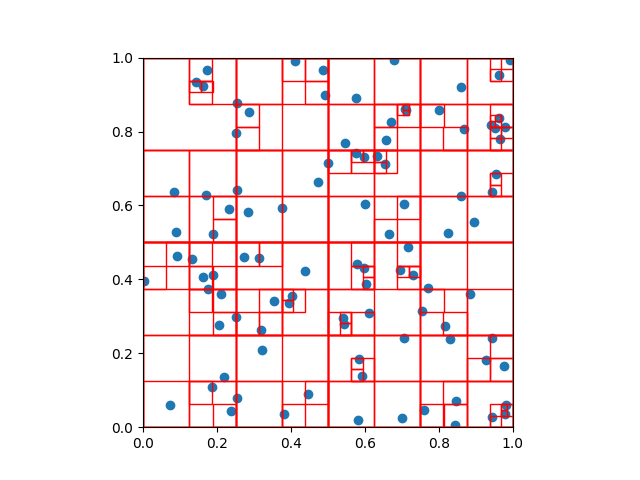

In [9]:
n_crit = 2

temp_bh = bh.BH(particles, 0, n_crit=n_crit)
temp_bh.create_root()
temp_bh.root.create_tree()
temp_bh.plot()

del n_crit, temp_bh

With the ability to create a quadtree, we now turn to how this can be used to approximate the pairwise interaction. In the original paper this is achieved through a centre of mass approximation for collections of particles that are sufficiently far away. 

For each particle, we recursively work down the tree from the root, evaluating for each cell the ratio of the side length of the cell to the distance to the cell's centre (of mass) (or $l/D$) against a value $\theta$, which is often chosen to be $0.5$. Cells are considered to be far away in the case that 
$$
\theta > \frac{l}{D} \quad \Longrightarrow \quad l < \theta D \, .
$$
For $\theta = 0.5$ this is equivalent to cases where the distance is greater than twice the side length of the cell. 

If this $\theta$ condition is satisfied, we 'interact' instead with the cell, using for example a centre of mass approximation, for the collection of particles in that cell. We then no longer go any deeper within the children of that cell. 

If the $\theta$ condition is not satisfied, we continue recursion through the tree, looking in turn at each cell's children, and that child's children etc. Only stopping in the case a branch is reached, at which point pairiwise interaction must then be performed for each particle in that given cell. Cells containing the particle of interest are also never interacted with, and always have children looked through, unless it is a leaf with more than just the particle of interest, where all other particles are then interacted with. This code is found as part of the `RootCell` class in [packages/bh/cells/rootcell.py](packages/bh/cells/rootcell.py), under the `evaluate_particle_potentials`. (Requiring of course that the relevant CoM have been filled in). 

![Barnes-Hut General interaction scheme](Figures/bh_interaction.drawio.svg)

### Centre of Mass Approximation

We first will use this alogorithm with a centre of mass interaction scheme to calculate the potentials and forces from this method. To do this, we first traverse the tree backwards (starting from leaf cells), calculating for each leaf the centre of mass and total mass of the cell, in the case of one particle in the cell, this is simply the particles mass and centre. We must first do this for all of a parent's children, before then considering the parent itself, we achieve this by itererating backwards through a list of `Cell`s in the tree, ordered by their creation time, hence preserving 'heritage'. 

Once we reach a parent cell, we no longer calculate its centre of mass from the particles contained within, rather we do so from the various CoM **get this abbreviation in earlier** of the cell's children, treating each of those as if they were the particle. 

We repeat this up the full tree, so each cell will have a CoM and total mass associated with it. This can then be used as the approximation of far-field interaction when we later move down the tree again for each particle. 

This method is encapsulated in code from [packages/bh/bh.py](packages/bh/bh.py). Where we use $theta = 0.5$ and the default `n_crit = 2`, corresponding to one particle per cell. 

In [10]:
reset_particle_values(particles)

bh_com_method = bh.BH(particles, 0.5)
bh_com_method.create_root()
bh_com_method.root.create_tree()
bh_com_method.root.populate_mass_CoM()
bh_com_method.root.evaluate_particle_potentials(use_CoM_far=True)

bh_com_potentials = np.array([p.potential for p in particles])
bh_com_forces = np.array([p.force_per for p in particles])

And we can then evaluate the errors within this method. At this point, we will only show those errors for potentials. 

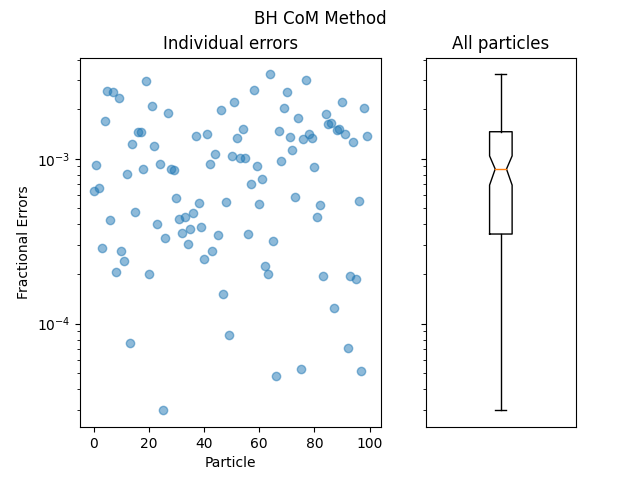

In [11]:
bh_com_potentials_fractional = abs(bh_com_potentials - pair_potentials) / pair_potentials

fig, (ax1, ax2) = plt.subplots(1, 2, sharey='all', gridspec_kw={'width_ratios':[2,1]})

ax1.plot(bh_com_potentials_fractional, 'o', alpha=0.5)
ax2.boxplot(bh_com_potentials_fractional, notch=True, whis=(0,100))

fig.suptitle('BH CoM Method')

ax1.set_yscale('log')
ax1.set_ylabel('Fractional Errors')
ax1.set_xlabel('Particle')
ax1.set_title('Individual errors')
ax2.set_title('All particles')
ax2.set_xticks([])

fig;

As we can see, this method is effective, offering errors below one in one hundred. However, there remain some issues with the method. The first being that as it stands, the only way to increase accuracy within this method is to reduce the value of $\theta$, corresponding to requiring cells to be further before they are considered far away, while this is possible, only marginal gains are possible **see figure ...** whilst still keeping $\theta$ large enough that performance gains are as expected. 

Secondly, this method also is very poor when considering both positive and negative charges. This arises as there is no truely useful concept of 'centre of charge', where for electrostatic situations, we should start to consider dipole and then further multipole moments to get reasonable approximation of far-field effects. 

### Multipole Approximation

The multipole from a collection of points is essentially an expansion of the potential, which will converge in the far-field. This is then truncated within computational methods, to get an approximation of these far field effects. As given in **FMM Paper**, the expansion at a point $z$ due to a collection of points sufficiently far away is given by, 
$$
\phi(z) = Q \log(z) + \sum_{k=1}^{\infty} \frac{a_k}{z^k} \, ,
$$
with, 
$$
Q = \sum_{i=1}^{m} q_i \, , \quad a_k = \sum_{i=1}^m \frac{-q_i z_i^k}{k} \, .
$$
Which converges for sufficiently large $z$ away. Note that this is for potentials of the form $+ \log(z - z_0)$ instead of the technically more correct negative sign. 

Using this formulation at each leaf cell, a multipole expansion is constructed. To propogate this up the tree, we use the 'Multipole to Multipole' equation, essentially just a Taylor expansion of a child's multipole about its parent's centre. Performing this for each child, and then summing the results allows calculation of a parent's multipole, and therefore propogation of the multipole up the tree. 

Hence we slightly modify our previous method. Now using 4 terms in the expansion. 

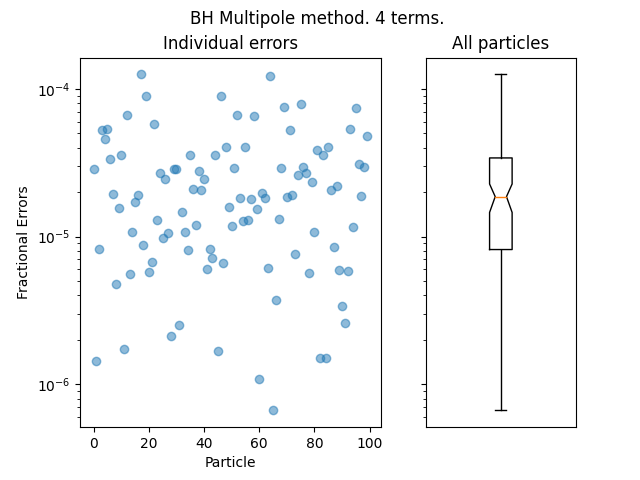

In [12]:
terms = 4

reset_particle_values(particles)

bh_multi_method = bh.BH(particles, 0.5, terms)
bh_multi_method.create_root()
bh_multi_method.root.create_tree()
bh_multi_method.root.populate_multipoles()
bh_multi_method.root.evaluate_particle_potentials()

bh_multi_potentials = np.array([p.potential for p in particles])
bh_multi_forces = np.array([p.force_per for p in particles])

bh_multi_potentials_fractional = abs(bh_multi_potentials - pair_potentials) / pair_potentials

fig, (ax1, ax2) = plt.subplots(1, 2, sharey='all', gridspec_kw={'width_ratios':[2,1]})

ax1.plot(bh_multi_potentials_fractional, 'o', alpha=0.5)
ax2.boxplot(bh_multi_potentials_fractional, notch=True, whis=(0,100))

fig.suptitle(f'BH Multipole method. {terms} terms. ')

ax1.set_yscale('log')
ax1.set_ylabel('Fractional Errors')
ax1.set_xlabel('Particle')
ax1.set_title('Individual errors')
ax2.set_title('All particles')
ax2.set_xticks([])

fig;

We can see immediately that this has no reduced the errors within all particles. Further terms will continue to lower these. This method is now also applicable to both positive and negative charges. 

**Need to show this**

## Fast Multipole Method

We now move to the complete implementation of the Fast Multipole Method (FMM) as presented by Greengard and Rokhlin. This method extends the use of various expansions in such a way that the time scaling becomes $O(N)$ for large $N$. This is achieved by calculating also for each cell a local expansion. This local expansion now converges inside the cell of interest, and if correctly constructed, approximates the far-field interactions that will be felt by particles in the cell. 

As per the method presented by Greengard and Rokhlin, we still subdivide the space, however no no longer in a tree structure, rather as a series of increasing finer grained grids of cells. A parent-child relation does still remain, with each parent having 4 'children' in the lower Level, akin to the quadrants in the Barnes-Hut method. Within this structure, consideration of nearest neighbours is common, and we also introduce an "interaction list" for each cell, consisting of all other cells within the same level that are children of the parents nearest neighbours, but not the child's nearest neighbour. Indexing each of the cells within the matrix as a 2D `Tuple` we create a `Cell` class in [packages/fmm/cell.py](packages/fmm/cell.py) to handle these methods. 

The method begins with the calculation of multipole coefficients within each cell in the finest grained level, due to the particles contained within each (should there be any). As in Barnes-Hut, we can then use the Multipole-to-Multipole method to propogate these up to parents, and therefore all cells in coarser grained levels. 

Now moving down (from coarsest to finest grained) the structure, local expansions for each cell are calculated, and then propogated to children. This is achieved in two parts, first Multipole-to-Local, and then Local-to-Local. 

Starting with Multipole-to-Local, we consider a cell and its corresponding interaction list. For each 'interactor' in this set, we apply the formula below construct a local expansion of the effects of the multipole of that cell. For a multipole expansion in the interactor cell (located at $z_0$) of the form, 
$$
\phi(z) = b_0 \log(z - z_0) + \sum_{k=1}^{\infty} \frac{b_k}{(z - z_0)^k} \, ,
$$
the local expansion 
$$
\phi(z) = \sum_{l=0}^{\infty} c_l z^l
$$
will have coefficients
$$
c_0 = a_0 \log(-z_0) + \sum_{k=1}^{\infty} \frac{b_k}{z_0^k}(-1)^k \, , \quad
c_l = \frac{-b_0}{l z_0^l} + \frac{1}{z_0^l} \sum_{k=1}^{\infty} \frac{b_k}{z_0^k} \binom{l+k-1}{k-1} (-1)^k \, \text{ for } l \geq 1 \, .
$$
This local expansion converges, and can therefore be truncated after a certain number of terms, while still remaining accurate to within some bound. 

As this is just a linear sum, coefficients from all expansions in a cells interaction list can simply be summed. Note also that for free space conditions, the regions at which cells should be for the coarsest two levels are empty (no interaction list), and give $\phi(z) = 0$ as a local expansion, hence we start with the third coarsest level. 

Starting at this level and performing for every cell, we now have a representation for the far-field interactions for every cell, and now wish to propogate these to the children in the child level. This is achieved with the Local-to-Local method, and is simply translation, and can be completed with application of Maclaurin's theorem. 

Moving then to the next lower level, the results of Multipole-to-Local expansions from interaction lists can be added to the those from a parent's Local-to-Local, to have a set of Local coefficients for each cell in the below level. These two methods can then be repeated down the entire structre, with the end goal of a being a set of Local coefficients for the finest level. 

Due to the nature of the interaction lists as we move down the strucuture, each of these local expansions represent the complete contribution to far-field interaction for a given cell. Hence to evaluate a given particle, this can be used for the far-field, summed with near-field contribution from all particles within the same cell and nearest-neighbour cells. 

The total number of levels is chosen such that for a reasonably uniform collection of particles, there will be roughly one particle per cell at the finest grain, hence a max level number (indexed from $0$) of $l = \text{floor}[\frac{1}{2} \log_2(N)]$. (As there are $2^l$ cells in level $l$). 

Implementation of this was achieved with a `Level` ([packages/fmm/level.py](packages/fmm/level.py)) class, containing the methods described above, and a further `Finest Level` to manage initial creation of multipoles, 'storage' of particles in each cell, and their eventual evaluation. The overall method is then encapsulated in the `FMM` class in [packages/fmm/fmm.py](packages/fmm/fmm.py). 

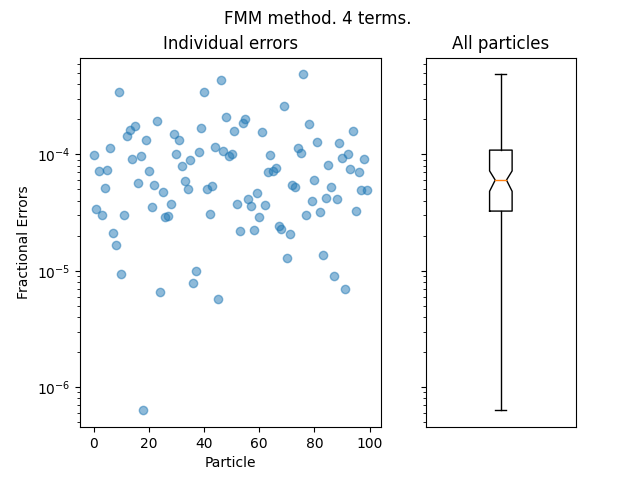

In [13]:
terms = 4

reset_particle_values(particles)

fmm_method = fmm.FMM(particles, terms)
fmm_method.finest_level.populate_with_particles(particles)
# Initial multipoles, and M2M
fmm_method.upward_pass()
# M2L and L2L
fmm_method.downward_pass()
fmm_method.finest_level.evaluate_particles()

fmm_potentials = np.array([p.potential for p in particles])
fmm_forces = np.array([p.force_per for p in particles])

fmm_potentials_fractional = abs(fmm_potentials - pair_potentials) / pair_potentials

fig, (ax1, ax2) = plt.subplots(1, 2, sharey='all', gridspec_kw={'width_ratios':[2,1]})

ax1.plot(fmm_potentials_fractional, 'o', alpha=0.5)
ax2.boxplot(fmm_potentials_fractional, notch=True, whis=(0,100))

fig.suptitle(f'FMM method. {terms} terms. ')

ax1.set_yscale('log')
ax1.set_ylabel('Fractional Errors')
ax1.set_xlabel('Particle')
ax1.set_title('Individual errors')
ax2.set_title('All particles')
ax2.set_xticks([])

fig;

For the same number of terms we see that there is a greater error associated than for the BH Multipole method, however, in a similar way, increasing the number of terms will decrease these errors **see later**. 

# Results and Discussion

Various tests on the methods were conducted using notebooks found in [tests](tests). 

In [16]:
import tests

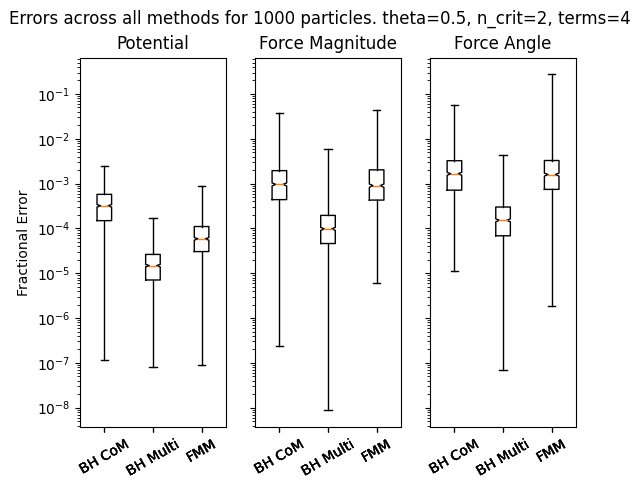

In [17]:
fig = tests.errors.plots.general('tests/errors/data/general.npz')

# Conclusions